In [1]:
# Copyright (c) 2024，WuChao D-Robotics.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import cv2
import numpy as np
from scipy.special import softmax
from time import time
from hobot_dnn import pyeasy_dnn as dnn

In [2]:
coco_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", 
    "bus", "train", "truck", "boat", "traffic light", 
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", 
    "cat", "dog", "horse", "sheep", "cow", 
    "elephant", "bear", "zebra", "giraffe", "backpack", 
    "umbrella", "handbag", "tie", "suitcase", "frisbee", 
    "skis", "snowboard", "sports ball", "kite", "baseball bat", 
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", 
    "wine glass", "cup", "fork", "knife", "spoon", 
    "bowl", "banana", "apple", "sandwich", "orange", 
    "broccoli", "carrot", "hot dog", "pizza", "donut", 
    "cake", "chair", "couch", "potted plant", "bed", 
    "dining table", "toilet", "tv", "laptop", "mouse", 
    "remote", "keyboard", "cell phone", "microwave", "oven", 
    "toaster", "sink", "refrigerator", "book", "clock", 
    "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]

yolo_colors = [
    (56, 56, 255), (151, 157, 255), (31, 112, 255), (29, 178, 255),
    (49, 210, 207), (10, 249, 72), (23, 204, 146), (134, 219, 61),
    (52, 147, 26), (187, 212, 0), (168, 153, 44), (255, 194, 0),
    (147, 69, 52), (255, 115, 100), (236, 24, 0), (255, 56, 132),
    (133, 0, 82), (255, 56, 203), (200, 149, 255), (199, 55, 255)]

def draw_detection(img, box, score, class_id):
    x1, y1, x2, y2 = box
    color = yolo_colors[class_id%20]
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    label = f"{coco_names[class_id]}: {score:.2f}"
    (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

    label_x = x1
    label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

    # Draw a filled rectangle as the background for the label text
    cv2.rectangle(
        img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color, cv2.FILLED
    )

    # Draw the label text on the image
    cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

# matplotlib 绘制图像到Web
from  matplotlib import pyplot as plt
%matplotlib inline
def cv2_img2plt_img(cv2_img):
    if cv2_img.ndim==3:  # 彩图
        return cv2_img[:,:,::-1]
    else:                # 灰度图
        return cv2_img
def jshow(cv2_img, size=4):
    plt.figure(figsize=(size, size))
    plt.imshow(cv2_img2plt_img(cv2_img), plt.cm.gray)
    plt.show()

In [3]:
try:
    del(quantize_model)
except:
    print("No Model Loaded.")

No Model Loaded.


In [4]:
# 读取horizon_quantize模型, 并打印这个horizon_quantize模型的输入输出Tensor信息
quantize_model_path = "yolov8s_640x640_NCHW_Dequantize_modified.bin"

begin_time = time()
quantize_model = dnn.load(quantize_model_path)
print("\033[0;31;40m" + "Load horizon quantize model time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

print("-> input tensors")
for i, quantize_input in enumerate(quantize_model[0].inputs):
    print(f"intput[{i}], name={quantize_input.name}, type={quantize_input.properties.dtype}, shape={quantize_input.properties.shape}")

print("-> output tensors")
for i, quantize_input in enumerate(quantize_model[0].outputs):
    print(f"output[{i}], name={quantize_input.name}, type={quantize_input.properties.dtype}, shape={quantize_input.properties.shape}")

[C][315427][04-12][20:33:52:118][configuration.cpp:49][EasyDNN]EasyDNN version: 0.5.4
Load horizon quantize model time = 414.08 ms
-> input tensors
intput[0], name=images, type=uint8, shape=(1, 3, 640, 640)
-> output tensors
output[0], name=output0, type=int32, shape=(1, 64, 80, 80)
output[1], name=331, type=int32, shape=(1, 64, 40, 40)
output[2], name=345, type=int32, shape=(1, 64, 20, 20)
output[3], name=324, type=int32, shape=(1, 80, 80, 80)
output[4], name=338, type=int32, shape=(1, 80, 40, 40)
output[5], name=352, type=int32, shape=(1, 80, 20, 20)
[BPU_PLAT]BPU Platform Version(1.3.3)!
[HBRT] set log level as 0. version = 3.15.29.0
[DNN] Runtime version = 1.19.3_(3.15.29 HBRT)
[A][DNN][packed_model.cpp:237][Model](2024-04-12,20:33:52.429.725) [HorizonRT] The model builder version = 1.18.2


In [5]:
# 提前将反量化系数准备好
s_bboxes_scale = quantize_model[0].outputs[0].properties.scale_data[:,np.newaxis]
m_bboxes_scale = quantize_model[0].outputs[1].properties.scale_data[:,np.newaxis]
l_bboxes_scale = quantize_model[0].outputs[2].properties.scale_data[:,np.newaxis]
s_clses_scale = quantize_model[0].outputs[3].properties.scale_data[np.newaxis, :, np.newaxis, np.newaxis]
m_clses_scale = quantize_model[0].outputs[4].properties.scale_data[np.newaxis, :, np.newaxis, np.newaxis]
l_clses_scale = quantize_model[0].outputs[5].properties.scale_data[np.newaxis, :, np.newaxis, np.newaxis]

# DFL求期望的系数, 只需要生成一次
weights_static = np.array([i for i in range(16)]).astype(np.float32)[np.newaxis, :, np.newaxis]
print(f"{weights_static.shape = }")

# 提前准备一些索引, 只需要生成一次
static_index = np.arange(8400)
print(f"{static_index.shape = }")

# anchors, 只需要生成一次
s_anchor = np.stack([np.tile(np.linspace(0.5, 79.5, 80), reps=80), 
                     np.repeat(np.arange(0.5, 80.5, 1), 80)], axis=0)
m_anchor = np.stack([np.tile(np.linspace(0.5, 39.5, 40), reps=40), 
                     np.repeat(np.arange(0.5, 40.5, 1), 40)], axis=0)
l_anchor = np.stack([np.tile(np.linspace(0.5, 19.5, 20), reps=20), 
                     np.repeat(np.arange(0.5, 20.5, 1), 20)], axis=0)
print(f"{s_anchor.shape = }")
print(f"{m_anchor.shape = }")
print(f"{l_anchor.shape = }")

# 输入图像大小, 一些阈值, 提前计算好
input_image_size = 640
conf=0.5
iou=0.5
conf_inverse = -np.log(1/conf - 1)
print("iou threshol = %.2f, conf threshol = %.2f"%(iou, conf))
print("sigmoid_inverse threshol = %.2f"%conf_inverse)

weights_static.shape = (1, 16, 1)
static_index.shape = (8400,)
s_anchor.shape = (2, 6400)
m_anchor.shape = (2, 1600)
l_anchor.shape = (2, 400)
iou threshol = 0.50, conf threshol = 0.50
sigmoid_inverse threshol = -0.00


In [6]:
# 测试或打印反量化系数
for i in range(6):
    print(quantize_model[0].outputs[i].properties.scale_data.shape)
# print(quantize_model[0].outputs[3].properties.scale_data)

(64,)
(64,)
(64,)
(80,)
(80,)
(80,)


In [7]:
# 读取一张bgr8格式的图像, 并进行可视化
begin_time = time()
img = cv2.imread("/root/05_yolov8s_seg/99_yolov5s_demo/kite.jpg")
# img = cv2.imread("/root/05_yolov8s_seg/bus.jpg")
print("\033[0;31;40m" + "cv2.imread time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")
print(img.shape)
# jshow(img)

cv2.imread time = 155.88 ms
(900, 1352, 3)


In [8]:
input_tensor = np.zeros_like(img)
begin_time = time()
input_tensor = img.copy()
print("\033[0;31;40m" + "Deep Copy image time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

resized_img = cv2.resize(img, (input_image_size, input_image_size), interpolation=cv2.INTER_NEAREST)

# 利用resize的方式进行前处理
begin_time = time()
input_tensor = cv2.cvtColor(input_tensor, cv2.COLOR_BGR2RGB)

input_tensor = cv2.resize(input_tensor, (input_image_size, input_image_size), interpolation=cv2.INTER_NEAREST)
# input_tensor = np.array(input_tensor) / 255.0  # bi模型无需归一化
input_tensor = np.transpose(input_tensor, (2, 0, 1))
input_tensor = np.expand_dims(input_tensor, axis=0).astype(np.uint8)  # NCHW
print("\033[0;31;40m" + "Pre Process time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")
print(f"{input_tensor.shape = }")

Deep Copy image time = 2.38 ms
Pre Process time = 5.75 ms
input_tensor.shape = (1, 3, 640, 640)


In [9]:
# 推理
begin_time = time()
quantize_outputs = quantize_model[0].forward(input_tensor)
print("\033[0;31;40m" + "Forward time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

Forward time = 11.42 ms


In [10]:
# 转为numpy
begin_time = time()
s_bboxes = quantize_outputs[0].buffer
m_bboxes = quantize_outputs[1].buffer
l_bboxes = quantize_outputs[2].buffer
s_clses = quantize_outputs[3].buffer
m_clses = quantize_outputs[4].buffer
l_clses = quantize_outputs[5].buffer
print("\033[0;31;40m" + "buffer_2_numpy time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")
print(f"{s_bboxes.shape = }")
print(f"{m_bboxes.shape = }")
print(f"{l_bboxes.shape = }")
print(f"{s_clses.shape = }")
print(f"{m_clses.shape = }")
print(f"{l_clses.shape = }")


buffer_2_numpy time = 6.04 ms
s_bboxes.shape = (1, 64, 80, 80)
m_bboxes.shape = (1, 64, 40, 40)
l_bboxes.shape = (1, 64, 20, 20)
s_clses.shape = (1, 80, 80, 80)
m_clses.shape = (1, 80, 40, 40)
l_clses.shape = (1, 80, 20, 20)


In [11]:
# classify 分支反量化
begin_time = time()
s_clses = s_clses.astype(np.float32) * s_clses_scale
m_clses = m_clses.astype(np.float32) * m_clses_scale
l_clses = l_clses.astype(np.float32) * l_clses_scale
print("\033[0;31;40m" + "Classify Branch Dequantize time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

Classify Branch Dequantize time = 5.88 ms


In [12]:
# Reshape

begin_time = time()
s_clses = s_clses[0].reshape(80, -1)
m_clses = m_clses[0].reshape(80, -1)
l_clses = l_clses[0].reshape(80, -1)
print("\033[0;31;40m" + "Classify Branch Reshape time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

begin_time = time()
s_bboxes = s_bboxes[0].reshape(64, -1)
m_bboxes = m_bboxes[0].reshape(64, -1)
l_bboxes = l_bboxes[0].reshape(64, -1)
print("\033[0;31;40m" + "Bouding Box Branch Reshape time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

print(f"{s_bboxes.shape = }")
print(f"{m_bboxes.shape = }")
print(f"{l_bboxes.shape = }")
print(f"{s_clses.shape = }")
print(f"{m_clses.shape = }")
print(f"{l_clses.shape = }")

Classify Branch Reshape time = 0.77 ms
Bouding Box Branch Reshape time = 0.74 ms
s_bboxes.shape = (64, 6400)
m_bboxes.shape = (64, 1600)
l_bboxes.shape = (64, 400)
s_clses.shape = (80, 6400)
m_clses.shape = (80, 1600)
l_clses.shape = (80, 400)


In [13]:
# 利用numpy向量化操作完成阈值筛选（优化版）
s_static_index = np.arange(6400)
m_static_index = np.arange(1600)
l_static_index = np.arange(400)

begin_time = time()
s_class_ids = np.argmax(s_clses, axis=0)  # 针对8400行，挑选出80个分数中的最大值的索引
s_max_scores = s_clses[s_class_ids,s_static_index] # 使用最大值的索引索引相应的最大值
s_valid_indices = np.flatnonzero(s_max_scores >= conf_inverse)  # 得到大于阈值分数的索引，此时为小数字

m_class_ids = np.argmax(m_clses, axis=0)  # 针对8400行，挑选出80个分数中的最大值的索引
m_max_scores = m_clses[m_class_ids,m_static_index] # 使用最大值的索引索引相应的最大值
m_valid_indices = np.flatnonzero(m_max_scores >= conf_inverse)  # 得到大于阈值分数的索引，此时为小数字

l_class_ids = np.argmax(l_clses, axis=0)  # 针对8400行，挑选出80个分数中的最大值的索引
l_max_scores = l_clses[l_class_ids,l_static_index] # 使用最大值的索引索引相应的最大值
l_valid_indices = np.flatnonzero(l_max_scores >= conf_inverse)  # 得到大于阈值分数的索引，此时为小数字
print("\033[0;31;40m" + "Small, Medium, Big Feature Map Conf Threshold time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

print(f"{s_valid_indices.shape = }")
print(f"{m_valid_indices.shape = }")
print(f"{l_valid_indices.shape = }")

Small, Medium, Big Feature Map Conf Threshold time = 17.61 ms
s_valid_indices.shape = (18,)
m_valid_indices.shape = (27,)
l_valid_indices.shape = (1,)


In [14]:
# 利用筛选结果，索引分数值和id值
begin_time = time()
s_scores = s_max_scores[s_valid_indices]
s_ids = s_class_ids[s_valid_indices]

m_scores = m_max_scores[m_valid_indices]
m_ids = m_class_ids[m_valid_indices]

l_scores = l_max_scores[l_valid_indices]
l_ids = l_class_ids[l_valid_indices]
print("\033[0;31;40m" + "Small, Medium, Big Feature Map Conf Threshold time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")


print(f"{s_scores.shape = }")
print(f"{s_ids.shape = }")
print(f"{m_scores.shape = }")
print(f"{m_ids.shape = }")
print(f"{l_scores.shape = }")
print(f"{l_ids.shape = }")

Small, Medium, Big Feature Map Conf Threshold time = 1.13 ms
s_scores.shape = (18,)
s_ids.shape = (18,)
m_scores.shape = (27,)
m_ids.shape = (27,)
l_scores.shape = (1,)
l_ids.shape = (1,)


In [15]:
# 3个Classify分类分支：Sigmoid计算
begin_time = time()
s_scores = 1 / (1 + np.exp(-s_scores))
m_scores = 1 / (1 + np.exp(-m_scores))
l_scores = 1 / (1 + np.exp(-l_scores))
print("\033[0;31;40m" + "Classify Branch Sigmoid time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

Classify Branch Sigmoid time = 1.17 ms


In [16]:
# 3个Bounding Box分支：反量化
begin_time = time()
s_bboxes_float32 = s_bboxes[:,s_valid_indices].astype(np.float32) * s_bboxes_scale
m_bboxes_float32 = m_bboxes[:,m_valid_indices].astype(np.float32) * m_bboxes_scale
l_bboxes_float32 = l_bboxes[:,l_valid_indices].astype(np.float32) * l_bboxes_scale
print("\033[0;31;40m" + "Bounding Box Branch Dequantize time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

Bounding Box Branch Dequantize time = 3.25 ms


In [17]:
# 3个Bounding Box分支：dist2bbox（ltrb2xyxy）
begin_time = time()
s_ltrb_indices = np.sum(softmax(s_bboxes_float32.reshape(4, 16,-1), axis=1) * weights_static, axis=1)
s_anchor_indices = s_anchor[:,s_valid_indices]
s_x1y1 = s_anchor_indices - s_ltrb_indices[0:2]
s_x2y2 = s_anchor_indices + s_ltrb_indices[2:4]
s_dbboxes = np.vstack([s_x1y1, s_x2y2]).transpose(1,0)*8

m_ltrb_indices = np.sum(softmax(m_bboxes_float32.reshape(4, 16,-1), axis=1) * weights_static, axis=1)
m_anchor_indices = m_anchor[:,m_valid_indices]
m_x1y1 = m_anchor_indices - m_ltrb_indices[0:2]
m_x2y2 = m_anchor_indices + m_ltrb_indices[2:4]
m_dbboxes = np.vstack([m_x1y1, m_x2y2]).transpose(1,0)*16

l_ltrb_indices = np.sum(softmax(l_bboxes_float32.reshape(4, 16,-1), axis=1) * weights_static, axis=1)
l_anchor_indices = l_anchor[:,l_valid_indices]
l_x1y1 = l_anchor_indices - l_ltrb_indices[0:2]
l_x2y2 = l_anchor_indices + l_ltrb_indices[2:4]
l_dbboxes = np.vstack([l_x1y1, l_x2y2]).transpose(1,0)*32
print("\033[0;31;40m" + "Small, Medium, Big Feature Map dist2bbox(ltrb2xyxy) time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")


Small, Medium, Big Feature Map dist2bbox(ltrb2xyxy) time = 7.23 ms


In [18]:
# 大中小特征层阈值筛选结果拼接
begin_time = time()
dbboxes = np.concatenate((s_dbboxes, m_dbboxes, l_dbboxes), axis=0)
scores = np.concatenate((s_scores, m_scores, l_scores), axis=0)
ids = np.concatenate((s_ids, m_ids, l_ids), axis=0)
print("\033[0;31;40m" + "3 Feature Maps cat time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

print(f"{dbboxes.shape = }")
print(f"{scores.shape = }")
print(f"{ids.shape = }")

3 Feature Maps cat time = 1.61 ms
dbboxes.shape = (46, 4)
scores.shape = (46,)
ids.shape = (46,)


In [19]:
# nms
begin_time = time()
indices = cv2.dnn.NMSBoxes(dbboxes, scores, conf, iou)
print("\033[0;31;40m" + "nms time = %.3f ms"%(1000*(time() - begin_time)) + "\033[0m")
print(len(indices))

nms time = 1.010 ms
8


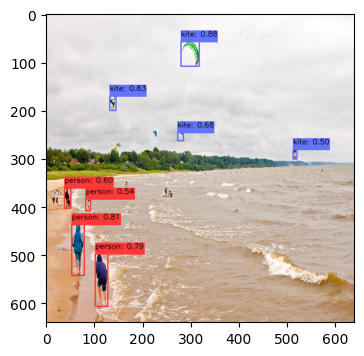

In [20]:
drew_img = resized_img.copy()
for index in indices:
    score = scores[index]
    class_id = ids[index]
    x1, y1, x2, y2 = dbboxes[index].astype(int)
    # print(class_id)
    # print("(%d, %d) <-> (%d, %d), %s: %.2f"%(x1,y1,x2,y2, coco_names[class_id], score))
    draw_detection(drew_img, (x1, y1, x2, y2), score, class_id)
jshow(drew_img)